# Абалон 

## Описание проекта 

Прогнозирование возраста морского ушка на основе физических измерений. Возраст морского ушка определяется путем разрезания скорлупы по конусу, окрашивания ее и подсчета количества колец под микроскопом - скучная и отнимающая много времени задача. Для прогнозирования возраста используются другие измерения, которые проще получить. Для решения проблемы может потребоваться дополнительная информация, такая как погодные условия и местоположение (следовательно, наличие продуктов питания).
 
 Из исходных данных были удалены примеры с отсутствующими значениями (в большинстве из них отсутствовало прогнозируемое значение), а диапазоны непрерывных значений были масштабированы для использования с ANN (путем деления на 200).

## Описание датасета


`Sex` - nominal - M, F, and I (infant)

`Length` - continuous - mm - Longest shell measurement

`Diameter` - continuous - mm - perpendicular to length

`Height` - continuous - mm - with meat in shell

`Whole weight` - continuous - grams - whole abalone

`Shucked weight` - continuous - grams - weight of meat

`Viscera weight` - continuous - grams - gut weight (after bleeding)

`Shell weight` - continuous - grams - after being dried

`Rings` (Age = Rings + 1.5) - integer - +1.5 gives the age in years (target)

## Общее исследование данных

In [2]:
import pandas as pd 
import polars as pl
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import f_oneway


PATH = 'dataset/abalone.csv'

plt.style.use('seaborn-v0_8-darkgrid')
pd.options.mode.chained_assignment = None

In [3]:
#загрузка датасета и первичный осмотр
df = pd.read_csv(PATH)
df.head() 

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
#для удобства переименуем стообцы
df.columns = df.columns.str.replace(' ','_').str.lower()

In [5]:
#количество дубликатов 
df.duplicated().sum()

0

In [6]:
#вывод основной информации
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4078 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4078 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4127 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [7]:
df.describe(include='all') # посмотрим на данные повнимательней

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177,4177.000000,4078.000000,4177.000000,4078.000000,4177.000000,4177.000000,4127.000000,4177.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.523992,0.407840,0.139516,0.827306,0.359367,0.180594,0.239072,9.933684
std,NaN,0.120093,0.099286,0.041827,0.490348,0.221963,0.109614,0.138942,3.224169
min,NaN,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,NaN,0.450000,0.350000,0.115000,0.440500,0.186000,0.093500,0.130000,8.000000
50%,NaN,0.545000,0.425000,0.140000,0.798500,0.336000,0.171000,0.235000,9.000000
75%,NaN,0.615000,0.480000,0.165000,1.150875,0.502000,0.253000,0.328250,11.000000


1. Надо изучить столбец `sex` в нём 4 уникальных значения
2. Есть 0 значение в `height` 
3. Надо проверить, что `Whole weight` всегда больше других весовых категорий 

In [8]:
#создадим целевую переменную по формуле target = rings + 1.5
df['rings'] = df['rings'] + 1.5
df.rename(columns={'rings':'target'}, inplace=True)

In [9]:
df['sex'].value_counts()

sex
M    1447
I    1276
F    1259
f     195
Name: count, dtype: int64

Новая категория появилась из-за строчной буквы

In [10]:
df['sex'] = df['sex'].replace('f', 'F')

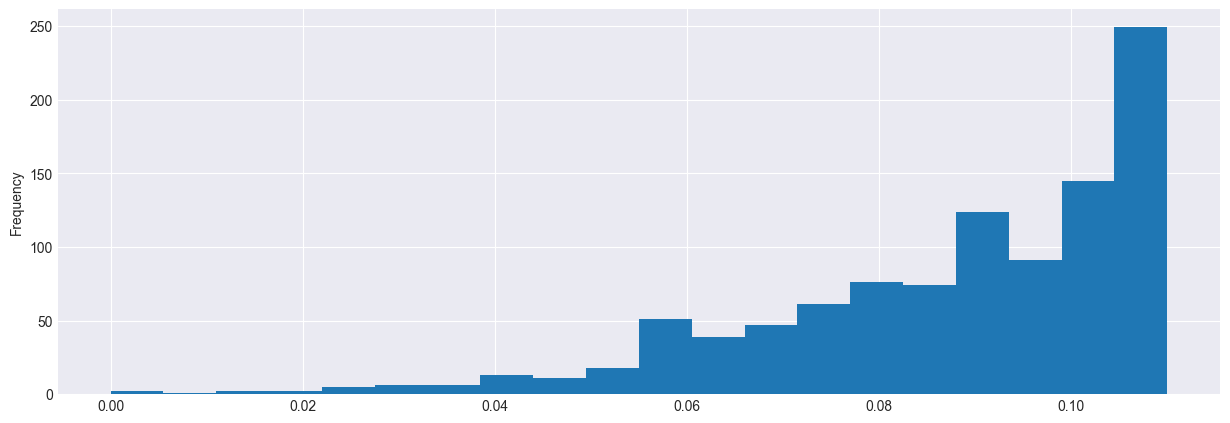

In [11]:
#посмотрим на распределение в высоте до 25 процентиля 
df.loc[df['height'] < df['height'].quantile(0.25), 'height'].plot(kind='hist', bins=20, figsize=(15, 5));

Было принято решение удалить удалить все значения в высоте до 0.02 включительно. Данные значения больше похожи на выброс/опечаку

In [12]:
df = df.loc[df['height'] > 0.02]

проверим у какого количество записей целое морское ушко весит меньше отдельно взятых элементов

In [13]:
df.loc[(df['whole_weight'] < df['shucked_weight']) | 
       (df['whole_weight'] < df['viscera_weight'] ) | 
       (df['whole_weight'] < df['shell_weight'])].shape[0]

4

У 4ех записей вес целого морского ушка меньше отдельных элементов, их можно спокойно удалить

In [14]:
df = df.loc[~((df['whole_weight'] < df['shucked_weight']) | 
              (df['whole_weight'] < df['viscera_weight'] ) | 
              (df['whole_weight'] < df['shell_weight']))]

In [15]:
#в данных присутствуют пропуски посмотрим на их количество их пропорцию 
pd.DataFrame({'Количество_пропусков': df.isna().sum(), 'Процент_пропусков': round(df.isna().mean()*100, 2)})

,Количество_пропусков,Процент_пропусков
sex,0,0.00
length,0,0.00
diameter,99,2.38
height,0,0.00
whole_weight,99,2.38
shucked_weight,0,0.00
viscera_weight,0,0.00
shell_weight,50,1.20
target,0,0.00


Пропусков в данных не очень много, максимум 2.37%. 
Делаю предположение, что `diameter`, `whole_weight`, `shell_weight` может зависить от пола и лучшим решением будет заполнить пропуски медианный значением в зависимости от пола

In [16]:
df['diameter'] = df['diameter'].fillna(df.groupby('sex')['diameter'].transform('median'))
df['whole_weight'] = df['whole_weight'].fillna(df.groupby('sex')['whole_weight'].transform('median'))
df['shell_weight'] = df['shell_weight'].fillna(df.groupby('sex')['shell_weight'].transform('median'))

**Вывод** 

1. Дубликаты не были обнаружены.
2. Таргет был изменен согласно формуле исследования. 
3. В столбце `sex` была опечатка, она была обработана 
4. Нулевые значения были удалены. 
5. Так же были удалены строки где `whole_weight` был меньше чем другие весовые категории  
6. В данных было замеченно не большое количество пропусков (не выше 2.38%), они были обработаны 


После обработви размерность данных изменилась с (4177, 9) до (4166, 9)

## Однофакторный анализ

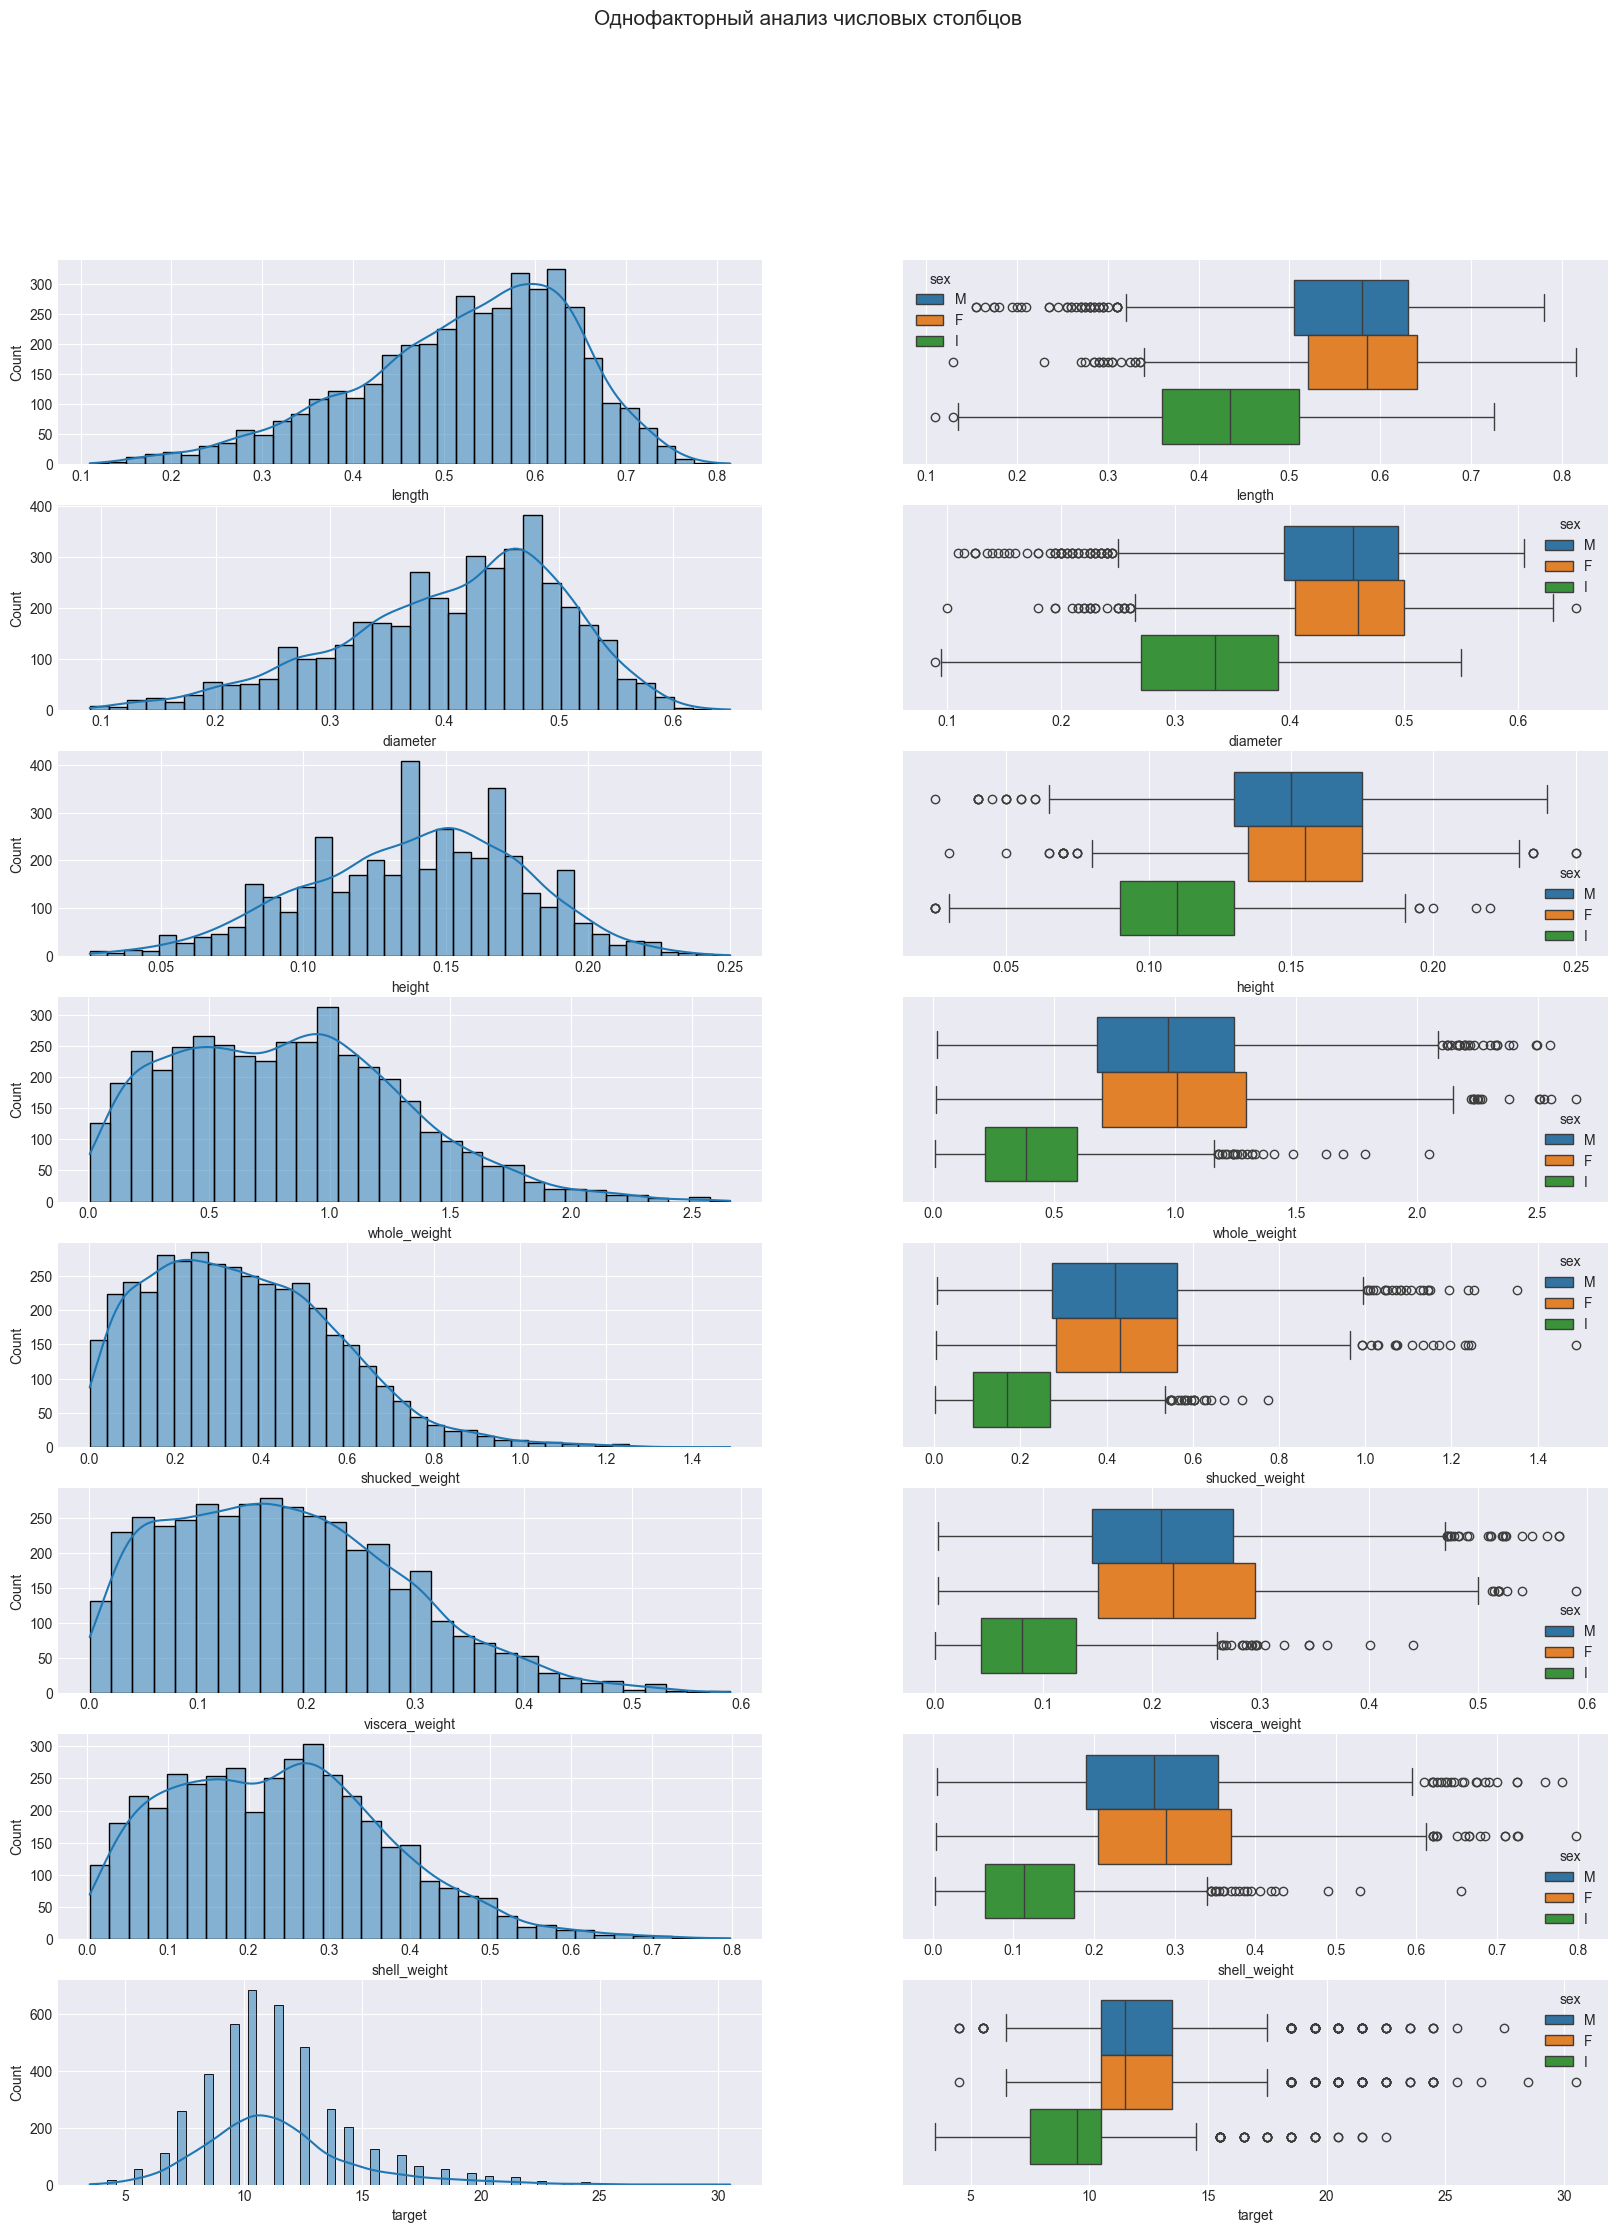

In [62]:
fig = plt.figure(figsize=(20, 25))
fig = plt.suptitle('Однофакторный анализ числовых столбцов', size=15)
for i, j in enumerate(df.select_dtypes('number').columns):
    plt.subplot(8, 2, i*2+1)
    sns.histplot(data=df, x=j, kde=True)
    plt.subplot(8, 2, i*2+2)
    sns.boxplot(data=df, x=j, hue='sex')
plt.show();

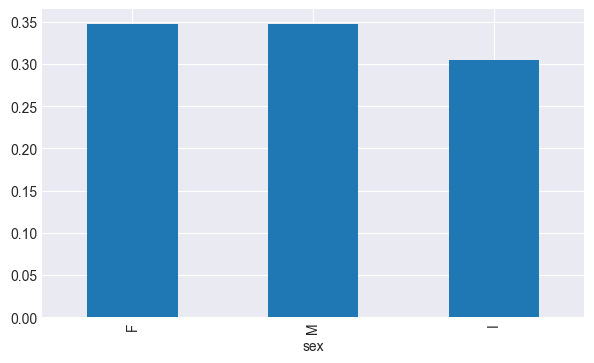

In [40]:
df['sex'].value_counts(normalize=True).plot(kind='bar', figsize=(7, 4));

In [27]:
# удалим значения с самым большим выбросом
df = df.loc[~(df['height'] > 0.35)]
df = df.loc[~(df['viscera_weight'] > 0.6)]
df = df.loc[~(df['shell_weight'] > 0.8)]

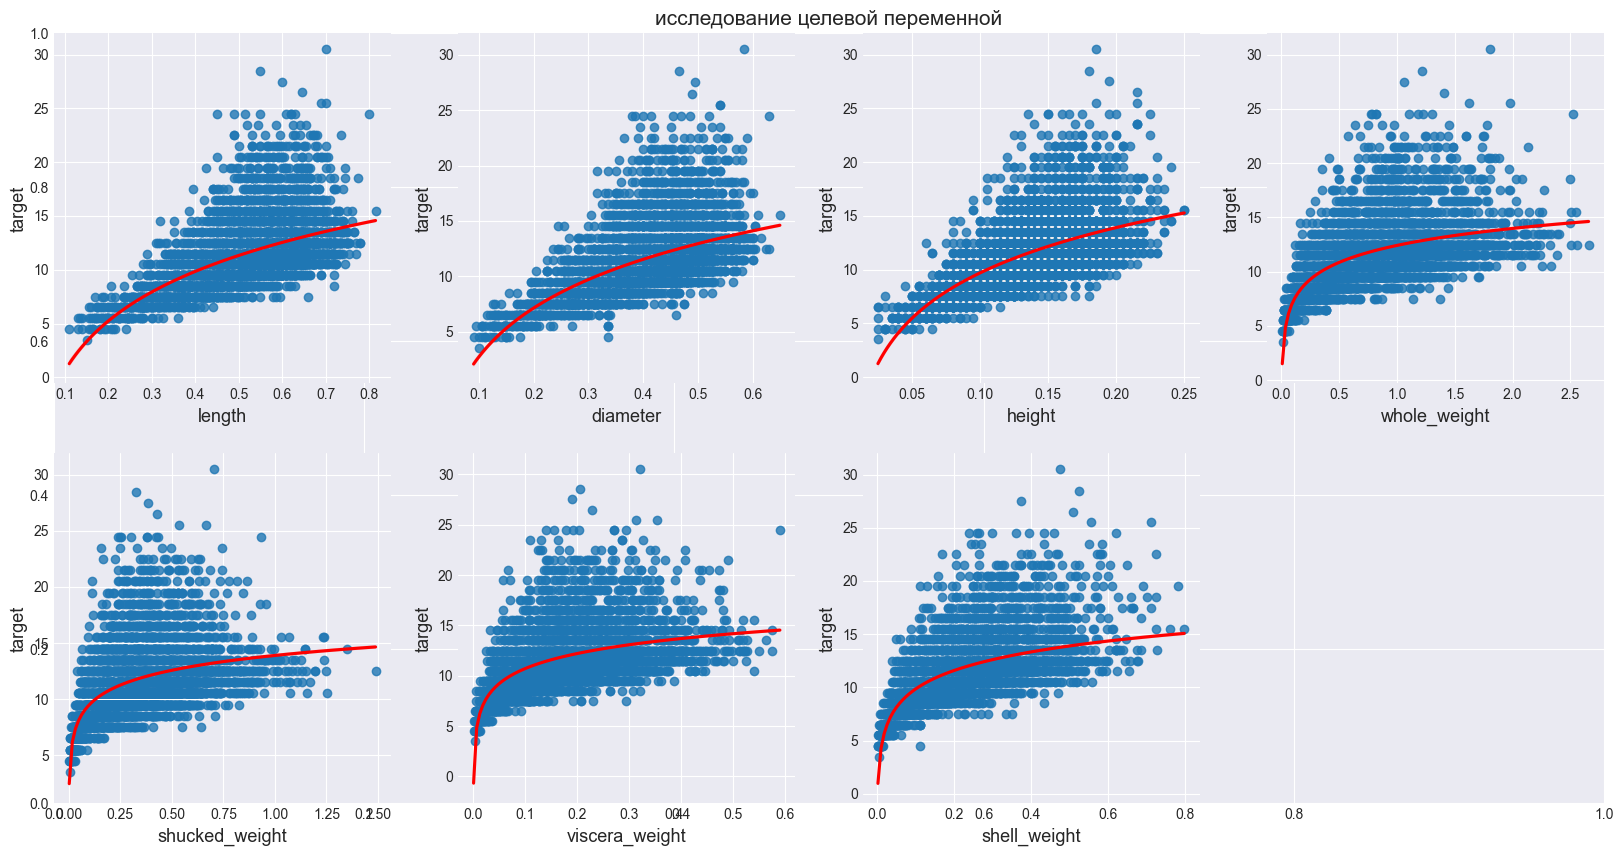

In [61]:
fig = plt.figure(figsize=(20,10))
plt.title('исследование целевой переменной', size=15)
for i, j in enumerate(df.select_dtypes('number').columns):
    if j == 'target':
        continue
    plt.subplot(2, 4, i+1)
    sns.regplot(data=df, x=j, y='target', logx=True, line_kws=dict(color="r"))
    plt.xlabel(j, size=13)
    plt.ylabel('target', size=13)
plt.show();

**Вывод**

Распределения стремятся к нормальному. 
В категориальном столбце `sex` распределение стремится к равномерному 
В данных имеются выбросы, отбрасывал сильно единычные случаи, было предположенно, что данные занослись с опечаткой. 


Надо так же узнать методику определения пола. Возможно ли определять пол на ранних стадиях развития морского ушка? 
Возможно, что часть выбросов в категориях `F` и `M` это на самом деле пол `I`. 

Так же наблюдается тенденция, что при увеличении параметра, тем больше целевая переменная

## Матрица корреляций 

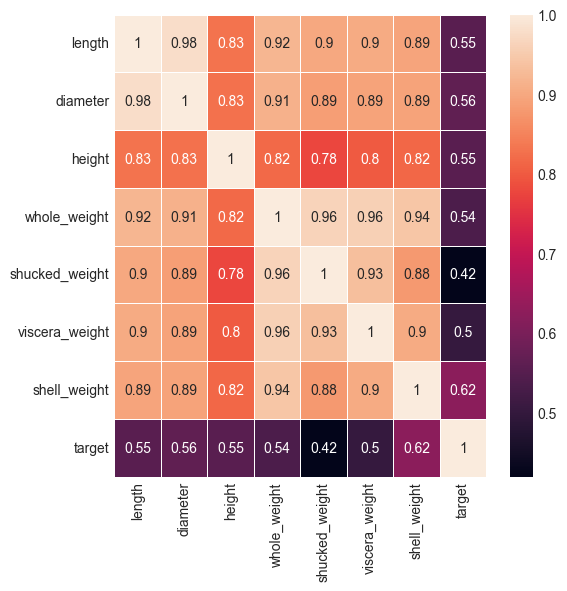

In [17]:
fig = plt.figure(figsize=(6, 6))
sns.heatmap(df.select_dtypes('number').corr(), annot=True,linewidth=.5)
plt.show();

In [18]:
Data = []

for c1 in df.columns:
    for c2 in df.columns:
        if df[c1].dtype == 'object' and df[c2].dtype != 'object':
            CategoryGroupLists = df.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No'})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes'})

pd.DataFrame.from_dict(Data)


,Category,Numerical,Is correlated
0,sex,length,Yes
1,sex,diameter,Yes
2,sex,height,Yes
3,sex,whole_weight,Yes
4,sex,shucked_weight,Yes
5,sex,viscera_weight,Yes
6,sex,shell_weight,Yes
7,sex,target,Yes


## Pandas и Polaris

In [20]:
df_big = df.copy()


while df_big.shape[0] < 1_000_000:
    df_big = pd.concat([df_big, df])


df_big.shape

(1004006, 9)

In [22]:
df_big.to_csv('dataset/df_big.csv', index=False)

Сравнение скорости загрузки pandas и polars

In [24]:
%%time 

df_pl = pl.read_csv('dataset/df_big.csv')

CPU times: total: 672 ms
Wall time: 146 ms


In [25]:
%%time 

df_pd = pd.read_csv('dataset/df_big.csv')

CPU times: total: 906 ms
Wall time: 954 ms


Выбор и фильтрация данных 

In [28]:
%%time 

df_pl.filter((pl.col('sex') == 'M') & (pl.col('diameter') > 0.45)).shape

CPU times: total: 62.5 ms
Wall time: 11 ms


(181714, 9)

In [35]:
%%time 

df_pd.loc[(df_pd['sex'] == 'M') & (df_pd['diameter'] > 0.45)].shape

CPU times: total: 93.8 ms
Wall time: 93 ms


(181714, 9)

Агрегация данных

In [37]:
%%time 

df_pd.groupby('sex').agg({'target':'mean', 'whole_weight': 'max'})

CPU times: total: 78.1 ms
Wall time: 78 ms


,target,whole_weight
sex,,
F,12.512405,2.8255
I,9.388013,2.0495
M,12.178645,2.7795


In [38]:
%%time 

df_pl.groupby('sex').agg([pl.mean('target'), pl.max('whole_weight')])

CPU times: total: 31.2 ms
Wall time: 32 ms


<timed eval>:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.


sex,target,whole_weight
str,f64,f64
"""I""",9.388013,2.0495
"""M""",12.178645,2.7795
"""F""",12.512405,2.8255
